# Generative Adversarial Network

Building a generative adversarial network (GAN) trained on the MNIST dataset.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

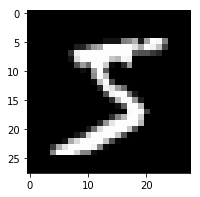

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.2)

        
    def forward(self, x): 
        # flatten
        x = x.view(-1, 28*28)
        
        # apply leaky relu activation to all hidden layers
        x = self.dropout(F.leaky_relu(self.fc1(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc3(x), 0.2))
        
        x = self.fc4(x)
        
        return x


## Generator

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        # pass x through all layers
        x = self.dropout(F.leaky_relu(self.fc1(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.fc3(x), 0.2))
                
        # final layer should have tanh applied
        x = F.tanh(self.fc4(x))
        
        return x

## Model hyperparameters

In [6]:
# input to discriminator
input_size = 28*28
# discriminator output
d_output_size = 1
# last hidden layer in discriminator
d_hidden_size = 32

# latent vector input for generator
z_size = 100
# size of generator output
g_output_size = 28*28
# size of first hidden layer in generator
g_hidden_size = 32

## Build complete network

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check architecture
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)



### Discriminator Losses

Total loss = loss from real image + loss from fake image

### Generator Loss

The generator wants the discriminator to think its images are real. So loss is the flipped "loss from fake image" in discriminator losses.

In [8]:
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    if smooth:
        # not to be too strict on the discriminator
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    labels = torch.zeros(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

In [9]:
import torch.optim as optim

lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training alternates between training the discriminator and the generator.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using flipped labels
3. Perform backpropagation + an optimization step to update the generator's weights

In [10]:
import pickle as pkl

# epoch number
num_epochs = 100

samples = []
losses = []

# Get some fixed data for sampling
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # Train with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up losses and backprop
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # Train with fake images and flipped labels
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # backprop
        g_loss.backward()
        g_optimizer.step()
        
        # Print stats
        if batch_i % 400 == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    # append losses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()

# Save samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3830 | g_loss: 0.6883
Epoch [    1/  100] | d_loss: 0.7668 | g_loss: 3.1404
Epoch [    1/  100] | d_loss: 1.0908 | g_loss: 2.6393
Epoch [    2/  100] | d_loss: 1.2982 | g_loss: 1.1008
Epoch [    2/  100] | d_loss: 1.1753 | g_loss: 1.1042
Epoch [    2/  100] | d_loss: 1.0874 | g_loss: 1.6588
Epoch [    3/  100] | d_loss: 0.9747 | g_loss: 2.9083
Epoch [    3/  100] | d_loss: 1.0724 | g_loss: 1.1101
Epoch [    3/  100] | d_loss: 1.4727 | g_loss: 0.4990
Epoch [    4/  100] | d_loss: 1.1590 | g_loss: 0.9996
Epoch [    4/  100] | d_loss: 1.1832 | g_loss: 1.0638
Epoch [    4/  100] | d_loss: 1.1652 | g_loss: 1.1463
Epoch [    5/  100] | d_loss: 1.2966 | g_loss: 1.0950
Epoch [    5/  100] | d_loss: 1.3616 | g_loss: 1.0312
Epoch [    5/  100] | d_loss: 1.2202 | g_loss: 1.1301
Epoch [    6/  100] | d_loss: 1.1609 | g_loss: 1.5148
Epoch [    6/  100] | d_loss: 1.1100 | g_loss: 1.2183
Epoch [    6/  100] | d_loss: 1.2376 | g_loss: 1.5296
Epoch [    7/  100] | d_loss

## Training loss

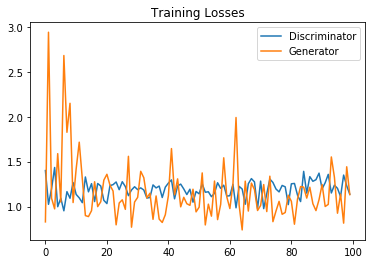

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Plot shows that D and G are fighting with each other
# if anything goes wrong, one or both of their loss will not be flutuating

## Generator samples from training

In [12]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [13]:
# Load samples from generator
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

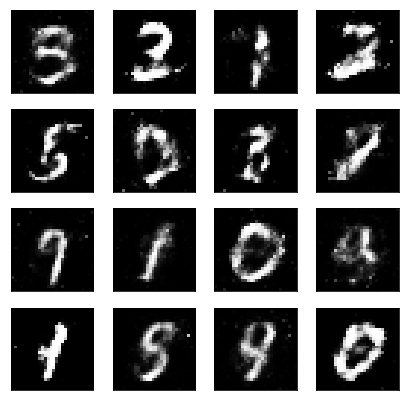

In [14]:
view_samples(-1, samples)

## Show Sample every 10 Epochs

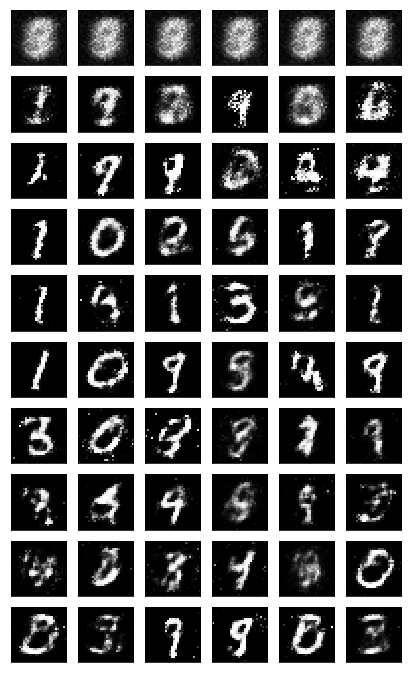

In [15]:
rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

Now I can generate infinite fake hand written digits

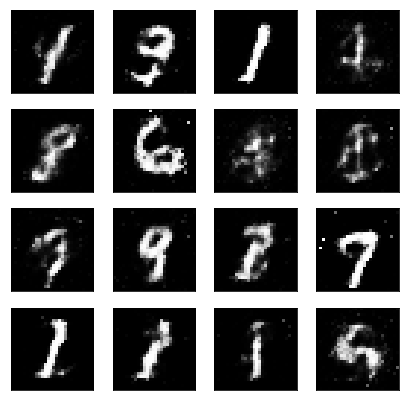

In [16]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)

view_samples(0, [rand_images])